In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.signal

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

In [34]:
mu = 1.
w = 2.*np.pi / 10.

def f(x, xext, yext):
    f = np.zeros((2))
    f[0] = (mu * x[0] - w * x[1] - (x[0]**2 + x[1]**2) * x[0])
    f[1] = (w * x[0] + mu * x[1] - (x[0]**2 + x[1]**2) * x[1])

    return f

def hopf(x0, y0, xext, yext, T, dt):

    x = np.zeros((2,T))
    x[0,0] = x0
    x[1,0] = y0
    for i in range(1, T):
        der = f(x[:,i-1], xext[i-1], yext[i-1])
        x[0,i] = x[0,i-1] + dt*der[0]
        x[1,i] = x[1,i-1] + dt*der[1]

    return x

def jac(x,T):
    jac = np.zeros((2,2,T))
    for i in range(T):
        jac[0,0,i] = mu - 3.*x[0,i]**2 - x[1,i]**2
        jac[0,1,i] = - w - 2. * x[0,i] * x[1,i]
        jac[1,0,i] = w - 2. * x[0,i] * x[1,i]
        jac[1,1,i] = mu - 3. * x[1,i]**2 - x[0,i]**2

    return jac

def Z_backwards(jac, T, dt, z0):
    Z = np.zeros((2,T))
    Z[0,-1] = z0[0]
    Z[1,-1] = z0[1]

    for i in range(T-2, -1, -1):
        Z[0,i] = Z[0,i+1] + dt * (jac[0,0,i+1]*Z[0,i+1] + jac[1,0,i+1]*Z[1,i+1])
        Z[1,i] = Z[1,i+1] + dt * (jac[0,1,i+1]*Z[0,i+1] + jac[1,1,i+1]*Z[1,i+1])

    return Z

def Z_forward(jac, T, dt, z0):
    Z = np.zeros((2,T))
    Z[0,0] = z0[0]
    Z[1,0] = z0[1]

    for i in range(1,T):
        Z[0,i] = Z[0,i-1] - dt * (jac[0,0,i-1]*Z[0,i-1] + jac[1,0,i-1]*Z[1,i-1])
        Z[1,i] = Z[1,i-1] - dt * (jac[0,1,i-1]*Z[0,i-1] + jac[1,1,i-1]*Z[1,i-1])

    return Z

In [54]:
cee, cie, cei, cii = 16, 12, 15, 3
a, mu = 1.5, 3. 
te, ti = 2.5, 3.75

def S(x):
    return 1.0 / (1.0 + np.exp(-a * (x - mu)))

def S_der(x):
    return (a * np.exp(-a * (x - mu))) / (1.0 + np.exp(-a * (x - mu))) ** 2

def f_wc(x, p):
    f = np.zeros((2))
    input_e = cee * x[0] - cie * x[1] + p[0]
    f[0] = ( -x[0] + (1. - x[0])*S(input_e) ) / te
    input_i = cei * x[0] - cii * x[1] + p[1]
    f[1] = ( -x[1] + (1. - x[1])*S(input_i) ) / ti

    return f

def wc(x0, y0, p, T, dt):

    x = np.zeros((2,T))
    x[0,0] = x0
    x[1,0] = y0
    for i in range(1, T):
        der = f_wc(x[:,i-1], p)
        x[0,i] = x[0,i-1] + dt*der[0]
        x[1,i] = x[1,i-1] + dt*der[1]

    return x

def jac_wc(x,p,T):
    jac = np.zeros((2,2,T))
    for i in range(T):
        input_e = cee * x[0,i] - cie * x[1,i] + p[0]
        jac[0, 0, i] = (-1.0 - S(input_e) + (1.0 - x[0,i]) * cee * S_der(input_e)) / te
        jac[0, 1, i] = ((1.0 - x[0,i]) * (-cie) * S_der(input_e)) / te
        input_i = cei * x[0,i] - cii * x[1,i] + p[1]
        jac[1, 0, i] = ((1.0 - x[1,i]) * cei * S_der(input_i)) / ti
        jac[1, 1, i] = (-1.0 - S(input_i) + (1.0 - x[1,i]) * (-cii) * S_der(input_i)) / ti

    return jac

[0.29987277 0.2492238 ]
period, inverse =  18.4525 0.054193198753556424


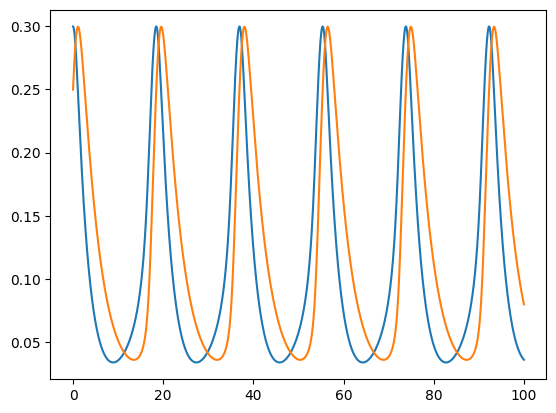

In [48]:
dt, duration = 0.01, 100.
time = np.arange(0., duration, dt)
T = len(time)
xext = np.zeros((T))
yext = np.zeros((T))
x0, y0 = 0.29987366, 0.24987086
timeseries = wc(x0, y0, [1.,0.], T, dt)

peaks = scipy.signal.find_peaks(timeseries[0,:])[0]
print(timeseries[:,peaks[-1]])
plist = []
for i in range(1,len(peaks)):
    plist.append(peaks[i] - peaks[i-1])
period = np.mean(plist) * dt
print("period, inverse = ", period, 1./period)

plt.plot(time, timeseries[0,:])
plt.plot(time, timeseries[1,:])
plt.show()

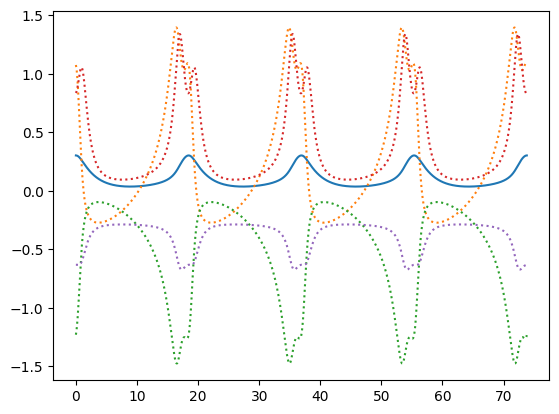

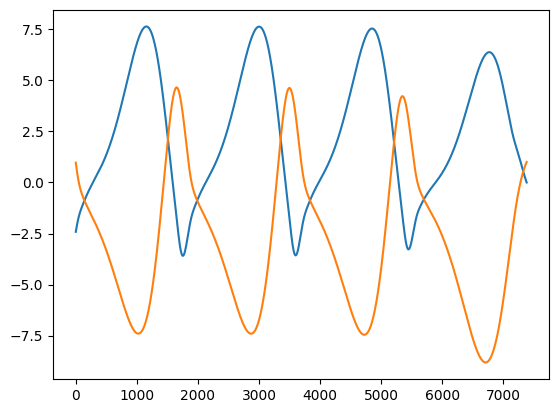

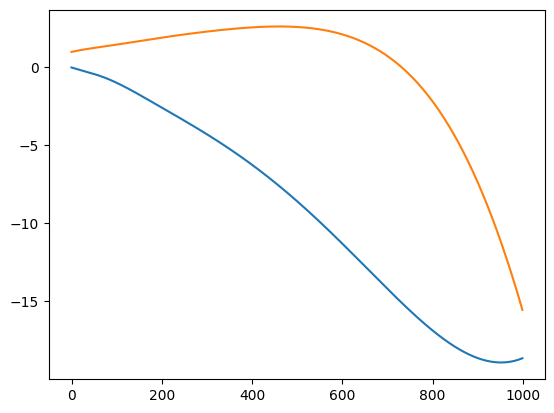

In [55]:
duration = 4. * period
time = np.arange(0., duration, dt)
T = len(time)
xext = np.zeros((T))
yext = np.zeros((T))
x0, y0 = 0.29987366, 0.24987086
timeseries = wc(x0, y0, [1.,0.], T, dt)

jacobian = jac_wc(timeseries, [1.,0.], T)

plt.plot(time, timeseries[0,:])
plt.plot(time, jacobian[0,0,:], linestyle=":")
plt.plot(time, jacobian[0,1,:], linestyle=":")
plt.plot(time, jacobian[1,0,:], linestyle=":")
plt.plot(time, jacobian[1,1,:], linestyle=":")
plt.show()
        
Z = Z_backwards(jacobian, T, dt, [0., 1.])

plt.plot(Z[0,:])
plt.plot(Z[1,:])
plt.show()


Z = Z_forward(jacobian, T, dt, [0., 1.])

plt.plot(Z[0,:1000])
plt.plot(Z[1,:1000])
plt.show()